## Merge Datasets for Analysis

In [8]:
import os
from glob import glob
import numpy as np
import pandas as pd
from scipy.integrate import trapz, cumtrapz, simps

from importlib import reload
import utils; reload(utils)
from utils import *

%matplotlib inline

In [2]:
#--Direct Link to USGS Data & Map
GotoUSGS('NY')


CLICK HERE FOR USGS GAGES: 
 https://waterdata.usgs.gov/nwis/uv?referred_module=sw&state_cd=NY&site_tp_cd=OC&site_tp_cd=OC-CO&site_tp_cd=ES&site_tp_cd=LK&site_tp_cd=ST&site_tp_cd=ST-CA&site_tp_cd=ST-DCH&site_tp_cd=ST-TS&format=station_list

CLICK HERE FOR MAP: 
 https://maps.waterdata.usgs.gov/mapper/index.html


Selection of Initial Hydrograph 
1. For unsteady flow analysis, the shape of the hydrograph and resulting volume of flow is of primary importance for modeling flood inundation extent. In order to develop a hydrograph with the appropriate shape, we will use the plots from FirstLook as a starting point.
2. The Hydrograph will then be stretched to the 100 yr Peak flow value, derived from the USGS PeakFQ software, using Bulletin 17-B methodology to analyze the peaks of record.


In [3]:
#--Read in gage data

data_dir =os.getcwd()
region_name = "TIOUGHNIOGA_RIVER"
output_dataset = os.path.join(data_dir, '{}.pkl'.format(region_name))
tsvs = glob(os.path.join(data_dir, '*.tsv'))

metadata = os.path.join(data_dir ,'gage_metadata.tsv')

if metadata in tsvs:
    tsvs.remove(metadata)
    
df = MergeDatsets(tsvs) 
df.head().style    

01509000_00060_dv.tsv
01509000_00060_iv.tsv
01509000_00065_iv.tsv
01509520_00065_iv.tsv
01511500_00065_iv.tsv


Gage Data
1. The gage located nearest our area of interest was installed in June of 2017, provideing limited data. Therefore we will need to look upstream to find another gage, and evaluate the Drainage Area and make some assumptions in order to approximate the downstream flows.

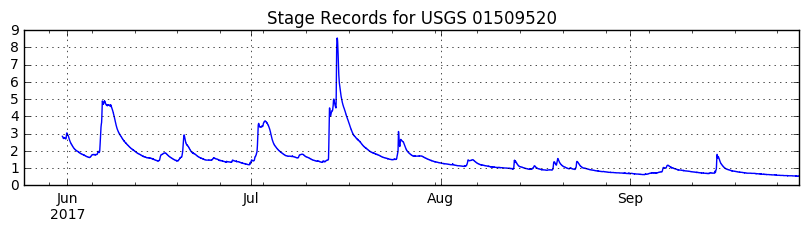

In [4]:
gage = '01509520_00065_iv'
df[gage]['2017-05-25':'2017-10'].plot(figsize=(10,2), grid='on', title = 'Stage Records for USGS {}'.format(gage.split('_')[0]))

From FirstLook, we know that the the peak of Record for the upstream gage, Cortland occurred on 2005-04-03. For this gage we have daily and instaneous values.  The corresponding plots will be different due to the averaging of data for the daily (mean) flow. Let's do some analysis to determine if this impacts the volume significantly.

Maximum Daily Flow = 12644.0 cfs
Maximum Daily Flow = 14211.0 cfs
Volume from Instantaneous Observations = 	3768994817
Volume from Daily Mean Observations = 		3961011255

Using Daily means yields = 192016438 more Cubic Feet of Water
(Daily means results in a difference of volume of ~ 5.0946326020616% )


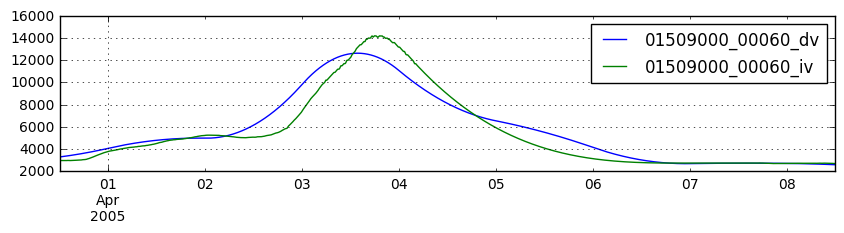

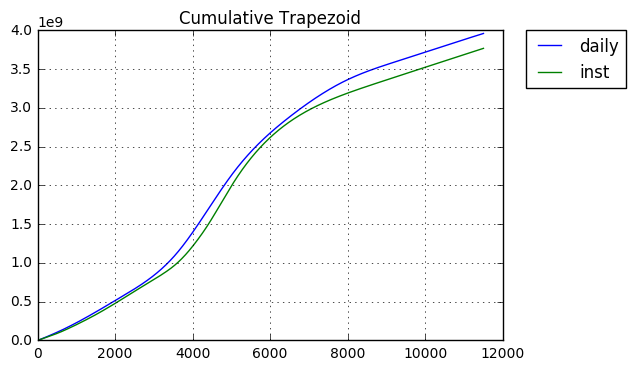

In [9]:
# Daily Plot
gage = '01509000_00060_dv'
daily_peak= df[gage]['2005-03-10':'2005-04-10'].copy()
daily_peak= daily_peak['2005-03-29':'2005-04-10'].resample('60S').asfreq()
daily_peak= daily_peak.interpolate(method = 'spline', order = 2)
daily_peak = daily_peak[3600:-3600]
daily_peak.plot(figsize=(10,2), grid='on')
print('Maximum Daily Flow = {} cfs'.format(round(daily_peak.max(),0)))

# Instantaneous Plot
gage = '01509000_00060_iv'
inst_peak= df[gage]['2005-03-15':'2005-04-10'].copy()
inst_peak= inst_peak['2005-03-29':'2005-04-10'].resample('60S').asfreq()

inst_peak= inst_peak.interpolate(method = 'spline', order = 3)
inst_peak = inst_peak[3600:-3600]
inst_peak.plot(figsize=(10,2), grid='on')
print('Maximum Daily Flow = {} cfs'.format(round(inst_peak.max(),0)))

plt.legend()

CompareVolumes(inst_peak, daily_peak)
PlotCumIntegral(inst_peak, daily_peak)

The Average daily maximum flow is 12,643 cfs compared with the peak instaneous recorded flow of 14,200. Let's integrate the area under the curve to estimate the difference in volume.

What if we were to stretch the daily means up to the peak flow value in the instantaneous records, how would that impact the volume?

Maximum Daily Flow = 14233.0 cfs
Maximum Daily Flow = 14211.0 cfs
Volume from Instantaneous Observations = 	3768994817
Volume from Daily Mean Observations = 		4099493019

Using Daily means yields = 330498202 more Cubic Feet of Water
(Daily means results in a difference of volume of ~ 8.768868584889358% )


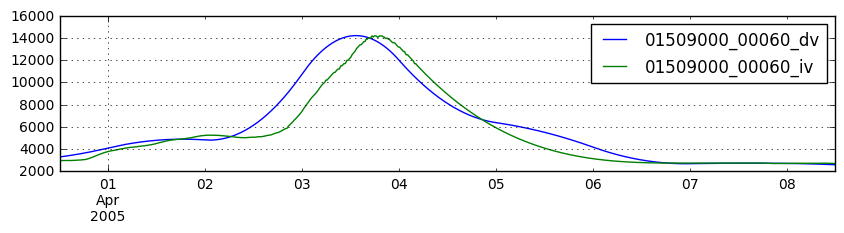

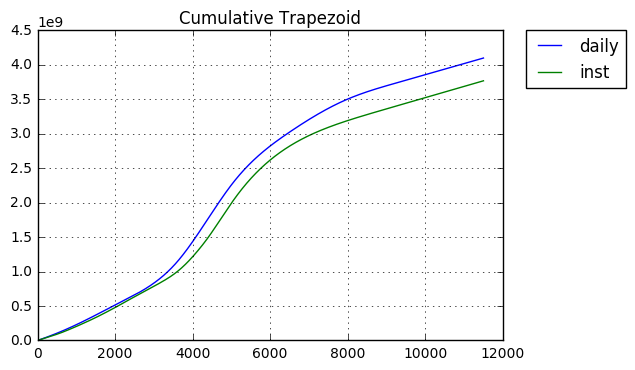

In [10]:
# Daily Plot
gage = '01509000_00060_dv'
daily_peak= df[gage]['2005-03-10':'2005-04-10'].copy()
#--Replace the daily mean on the day of peak flow, with the peak from the instantaneous record
daily_peak['2005-04-03 12:00:00'] = 14200.0 
daily_peak= daily_peak['2005-03-29':'2005-04-10'].resample('60S').asfreq()
daily_peak= daily_peak.interpolate(method = 'spline', order = 2)
daily_peak = daily_peak[3600:-3600]
daily_peak.plot(figsize=(10,2), grid='on')
print('Maximum Daily Flow = {} cfs'.format(round(daily_peak.max(),0)))


# Instantaneous Plot
inst_peak.plot(figsize=(10,2), grid='on')
print('Maximum Daily Flow = {} cfs'.format(round(inst_peak.max(),0)))

plt.legend()
CompareVolumes(inst_peak, daily_peak)
PlotCumIntegral(inst_peak, daily_peak)

#### Plot Inst & Daily to show missing data for the top event